This pipeline retrieves significant DEGs and perform appropriate filters to generate biologically relevant expression changing gene sets.

Filter set is:
- log2 FC > 1.
- min max expression > 2 TPM
- noise threshold > 0.5


In [1]:
import pandas, numpy, matplotlib_venn, umap

In [2]:
import sklearn, sklearn.decomposition, sklearn.preprocessing

In [3]:
import matplotlib, matplotlib.pyplot
matplotlib.rcParams.update({'font.size':20, 'font.family':'sans-serif', 'xtick.labelsize':30, 'ytick.labelsize':30, 'figure.figsize':(16, 9), 'axes.labelsize':40})

# 0. user-defined variables

In [4]:
DEG_folder = '/home/adrian/projects/reynisfjara/results/DEGs_DESeq2/'
expression_file = '/home/adrian/projects/reynisfjara/results/tpm/DESeq2_TPM_values.tsv'
annotation_file = '/home/adrian/projects/reynisfjara/results/annotation/annotation.csv'
results_table_dir = '/home/adrian/projects/reynisfjara/results/relevant_DEGs/'

mice = ['a3922', 'a4774', 'a4775', 'a4776']
trends = ['up', 'down']

expression_threshold = 2
discrete_fc_threshold = 1
noise_threshold = 1/2

# 1. read data

## 1.1. expression data

In [5]:
expression = pandas.read_csv(expression_file, sep='\t', index_col=0)
expression.head()

,a3922_0h_1,a3922_0h_2,a3922_0h_3,a3922_48h_1,a3922_48h_2,a3922_48h_3,a3922_72h_1,a3922_72h_2,a3922_72h_3,a4774_0h_1,...,a4775_72h_3,a4776_0h_1,a4776_0h_2,a4776_0h_3,a4776_48h_1,a4776_48h_2,a4776_48h_3,a4776_72h_1,a4776_72h_2,a4776_72h_3
ENSMUSG00000000001,65.244411,65.953285,64.396929,75.289955,71.147817,72.146832,67.786762,70.217188,70.219265,61.227221,...,68.440778,64.806231,65.619286,66.749396,64.425407,68.665136,68.419059,69.705546,70.717428,71.017699
ENSMUSG00000000003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSMUSG00000000028,5.945436,5.464240,4.924612,20.245428,19.780706,22.747363,19.239938,22.062649,20.547492,7.843197,...,14.565935,4.712688,3.690099,4.120889,7.220914,8.377850,9.611563,9.465468,10.235803,9.808747
ENSMUSG00000000037,0.220972,0.959207,0.258270,0.969948,1.149452,2.212842,0.989879,2.354492,1.813624,0.545637,...,0.989086,0.451844,0.523639,0.679725,2.862086,0.865126,1.973570,1.612622,2.148935,5.445061
ENSMUSG00000000049,0.061451,0.061879,0.096945,0.000000,0.071373,0.000000,0.059768,0.000000,0.000000,0.214027,...,0.761343,0.000000,0.125876,0.000000,0.000000,0.096454,0.130578,0.000000,0.000000,0.000000


## 1.2. annotation

In [6]:
annotation = pandas.read_csv(annotation_file, sep=',', index_col='ens_gene')
annotation.drop(columns=['Unnamed: 0', 'target_id'], inplace=True)
annotation.drop_duplicates(inplace=True)
print(annotation.shape)
annotation.head()

(53193, 3)


,gene_biotype,description,ext_gene
ens_gene,,,
ENSMUSG00000064336,Mt_tRNA,mitochondrially encoded tRNA phenylalanine [So...,mt-Tf
ENSMUSG00000064337,Mt_rRNA,mitochondrially encoded 12S rRNA [Source:MGI S...,mt-Rnr1
ENSMUSG00000064338,Mt_tRNA,mitochondrially encoded tRNA valine [Source:MG...,mt-Tv
ENSMUSG00000064339,Mt_rRNA,mitochondrially encoded 16S rRNA [Source:MGI S...,mt-Rnr2
ENSMUSG00000064340,Mt_tRNA,mitochondrially encoded tRNA leucine 1 [Source...,mt-Tl1


In [7]:
annotation.head()

,gene_biotype,description,ext_gene
ens_gene,,,
ENSMUSG00000064336,Mt_tRNA,mitochondrially encoded tRNA phenylalanine [So...,mt-Tf
ENSMUSG00000064337,Mt_rRNA,mitochondrially encoded 12S rRNA [Source:MGI S...,mt-Rnr1
ENSMUSG00000064338,Mt_tRNA,mitochondrially encoded tRNA valine [Source:MG...,mt-Tv
ENSMUSG00000064339,Mt_rRNA,mitochondrially encoded 16S rRNA [Source:MGI S...,mt-Rnr2
ENSMUSG00000064340,Mt_tRNA,mitochondrially encoded tRNA leucine 1 [Source...,mt-Tl1


# 2. define gene sets

In [8]:
log_file = 'messages.deseq2.filter.txt'
log = open(log_file, 'w')

for mouse in mice:
    condition_labels0 = ['{}_0h_{}'.format(mouse, i+1) for i in range(3)]
    condition_labels48 = ['{}_48h_{}'.format(mouse, i+1) for i in range(3)]
    condition_labels72 = ['{}_72h_{}'.format(mouse, i+1) for i in range(3)]
    
    for trend in trends:
        log.write('working with mouse {} and trend {}'.format(mouse, trend))
        
        container = []
        
        DEG_file = DEG_folder + mouse + '_' + trend + '.tsv'
        DEGs = pandas.read_csv(DEG_file, sep='\t', index_col=0)
        log.write('\t detected {} DEGs'.format(DEGs.shape[0]))
        
        rules = (DEGs['pvalue'] < 0.05) & (DEGs['padj'] < 0.1)
        sub = DEGs[rules]
        log.write('\t passed tests {}'.format(DEGs.shape[0]))
        
        for ensembl in DEGs.index:
            
            gene_name = ''; biotype = ''; description = ''
            try:
                gene_name = annotation.loc[ensembl]['ext_gene']
                biotype = annotation.loc[ensembl]['gene_biotype']
                description = annotation.loc[ensembl]['description'].split(' [')[0]
            except:
                pass
            
            log.write('\t\t working with {} ({})'.format(ensembl, gene_name))
            including = True
            
            #
            # filter 1 --- expression
            #
            tpms0 = []
            for label in condition_labels0:
                if label in expression.keys():
                    tpms0.append(expression[label][ensembl])
            tpm0 = numpy.median(tpms0)
            tpms48 = []
            for label in condition_labels48:
                if label in expression.keys():
                    tpms48.append(expression[label][ensembl])
            tpm48 = numpy.median(tpms48)
            tpms72 = []
            for label in condition_labels72:
                if label in expression.keys():
                    tpms72.append(expression[label][ensembl])
            tpm72 = numpy.median(tpms72)
            top = numpy.max([tpm0, tpm48, tpm72])
            
            #
            # filter 2 --- identify fold-changes using discrete values
            #        
            ###'_deseq2_'
            ###            [round(x, epsilon)/epsilon ] + 1
            ###  FC = abs  -------------------------------- > 1
            ###            [round(y, epsilon)/epsilon ] + 1
            ###
            ###
            ###  epsilon = 1
            sam48 = numpy.around(tpm48) + 1
            sam72 = numpy.around(tpm72) + 1
            ref = numpy.around(tpm0) + 1
            
            fc48 = sam48/ref; fc72 = sam72/ref
            log2FC48 = numpy.log2(fc48); log2FC72 = numpy.log2(fc72)
            
            #
            # filter 3 --- noise
            #
            tpms0_int = numpy.around(tpms0) + 1
            rsem_tpms0 = numpy.std(tpms0_int) / (numpy.sqrt(len(tpms0_int)) * numpy.mean(tpms0_int))
            
            tpms48_int = numpy.around(tpms48) + 1
            rsem_tpms48 = numpy.std(tpms48_int) / (numpy.sqrt(len(tpms48_int)) * numpy.mean(tpms48_int))
            
            tpms72_int = numpy.around(tpms72) + 1
            rsem_tpms72 = numpy.std(tpms72_int) / (numpy.sqrt(len(tpms72_int)) * numpy.mean(tpms72_int))
            noise = numpy.mean([rsem_tpms0, rsem_tpms48, rsem_tpms72])
            
            #
            # selection
            #
            if top < expression_threshold:
                including = False
                info = '\t\t\t WARNING: low-expression gene discarded. Expression changes from {:.3f} to {:.3f} and {:.3f}'.format(tpm0, tpm48, tpm72)
                log.write(info)
                
            if (including == True):
                # check that trend is consistent in both timepoints
                if (log2FC48*log2FC72) < 0:
                    including = False
                    info = '\t\t\t WARNING: inconsistent trend: {:.3f} and {:.3f}'.format(log2FC48, log2FC72)
                    log.write(info)
                # check that you are abs log2FC > 1 at both conditions
                if numpy.max([numpy.abs(log2FC48), numpy.abs(log2FC72)]) < 1:
                    including = False
                    info = '\t\t\t WARNING: small change gene discarded: Expressions: {:.2f}, {:.2f}, {:.2f}. Fold changes: {:.2f}, {:.2f}'.format(tpm0, tpm48, tpm72, log2FC48, log2FC72)
                    log.write(info)
                    
            if (including == True) and (noise > noise_threshold):
                including = False
                info = '\t\t\t WARNING: noisy gene discarded.'
                log.write(info)
            
            #
            # store DEGs that passed filters
            #
            if including == True:
                log.write('\t\t\t SUCCESS: expression: [{:.3f}, {:.3f}, {:.3f}]; log2FCs: [{:.2f}, {:.2f}]'.format(tpm0, tpm48, tpm72, log2FC48, log2FC72))
                print
                accumulative_expression_difference = numpy.log10(numpy.abs(tpm72-tpm0) + numpy.abs(tpm48-tpm0))
                accumulative_fold_change = log2FC48 + log2FC72
                
                box = [ensembl, gene_name, biotype, description, '{:.2f}'.format(tpm0), '{:.2f}'.format(tpm48), '{:.2f}'.format(tpm72), '{:.3f}'.format(log2FC48), '{:.3f}'.format(log2FC72), '{:.3f}'.format(accumulative_expression_difference), '{:.3f}'.format(accumulative_fold_change)]
                container.append(box)
                
        #
        # info about selection
        #
        log.write('\t pased filters {}\n'.format(len(container)))
        
        #print
        # store results
        #
        results_table_file = results_table_dir + 'deseq2_' + mouse + '_' + trend + '.tsv'
        f = open(results_table_file, 'w')
        f.write('ENSEMBL\tGene name\tBiotype\tDescription\tTPM @ T0\tTPM @ T48\tTPM @T72\tlog2FC @ T48\tlog2TPM @ T72\tAccumulative expression difference (log10 TPM)\tAccumulative log2FC\n')
        for box in container:
            info = '\t'.join(box)
            info = info + '\n'
            f.write(info)
        f.close()        
        
log.close()

# 3. find intersect

## 3.1. find intersect across up/down mutants

72


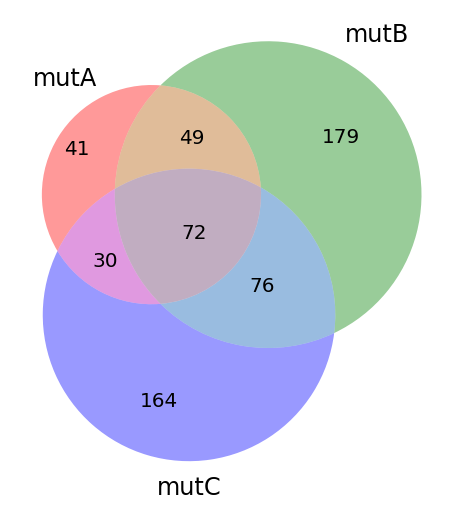

In [9]:
# up
trend = 'up'
all_degs = []
for mouse in mice[1:]:
    results_table_file = results_table_dir + 'deseq2_' + mouse + '_' + trend + '.tsv'
    df = pandas.read_csv(results_table_file, sep='\t', index_col=0)
    degs = df.index.to_list()
    all_degs.append(set(degs))
    
# Venn diagram
matplotlib_venn.venn3(all_degs, set_labels=('mutA', 'mutB', 'mutC'))

# define core
core_mut_up = list(all_degs[0] & all_degs[1] & all_degs[2])
print(len(core_mut_up))

54


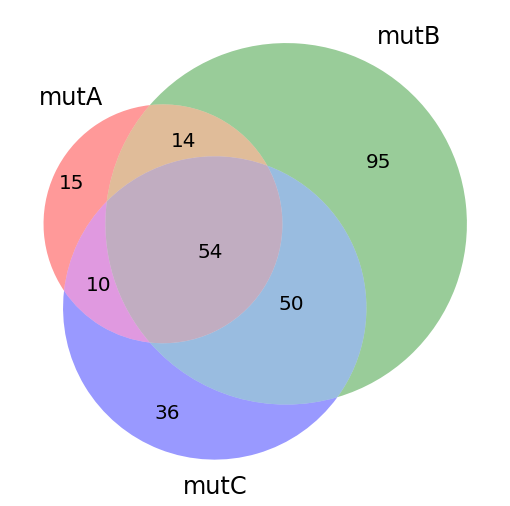

In [10]:
# down
trend = 'down'
all_degs = []
for mouse in mice[1:]:
    results_table_file = results_table_dir + 'deseq2_' + mouse + '_' + trend + '.tsv'
    df = pandas.read_csv(results_table_file, sep='\t', index_col=0)
    degs = df.index.to_list()
    all_degs.append(set(degs))
    
# Venn diagram
matplotlib_venn.venn3(all_degs, set_labels=('mutA', 'mutB', 'mutC'))

# define core
core_mut_down = list(all_degs[0] & all_degs[1] & all_degs[2])
print(len(core_mut_down))

## 3.2. find the intersect between WT and mutant phenotypes

602


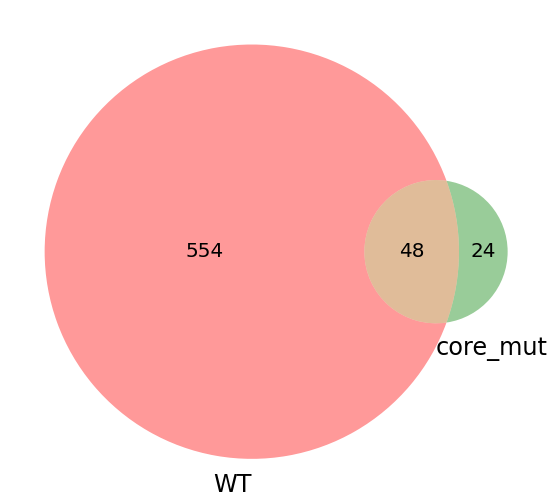

In [11]:
# up
trend = 'up'
mouse = 'a3922'
all_degs = []

results_table_file = results_table_dir + 'deseq2_' + mouse + '_' + trend + '.tsv'
df = pandas.read_csv(results_table_file, sep='\t', index_col=0)
wt_up = set(df.index.to_list())
print(len(wt_up))
    
# Venn diagram
matplotlib_venn.venn2([wt_up, set(core_mut_up)], set_labels=('WT', 'core_mut'))

In [12]:
index = 0
for element in core_mut_up:
    if element not in wt_up:
        index = index + 1
        gene_name = annotation.loc[element]['ext_gene']
        description = annotation.loc[element]['description'].split(' [')[0]
        print(index, element, gene_name, description)

1 ENSMUSG00000030428 Ttyh1 tweety family member 1
2 ENSMUSG00000038816 Ctnnal1 catenin (cadherin associated protein), alpha-like 1
3 ENSMUSG00000020648 Dus4l dihydrouridine synthase 4-like (S. cerevisiae)
4 ENSMUSG00000028713 Cyp4b1 cytochrome P450, family 4, subfamily b, polypeptide 1
5 ENSMUSG00000016496 Cd274 CD274 antigen
6 ENSMUSG00000047793 Sned1 sushi, nidogen and EGF-like domains 1
7 ENSMUSG00000073805 Insyn2a inhibitory synaptic factor 2A
8 ENSMUSG00000050994 Adgb androglobin
9 ENSMUSG00000044927 H1f10 H1.10 linker histone
10 ENSMUSG00000029605 Oas1b 2'-5' oligoadenylate synthetase 1B
11 ENSMUSG00000015467 Egfl8 EGF-like domain 8
12 ENSMUSG00000003617 Cp ceruloplasmin
13 ENSMUSG00000006235 Epor erythropoietin receptor
14 ENSMUSG00000030796 Tead2 TEA domain family member 2
15 ENSMUSG00000085684 4930469K13Rik RIKEN cDNA 4930469K13 gene
16 ENSMUSG00000022676 Snai2 snail family zinc finger 2
17 ENSMUSG00000041828 Abca8a ATP-binding cassette, sub-family A (ABC1), member 8a
18 ENSMU

295


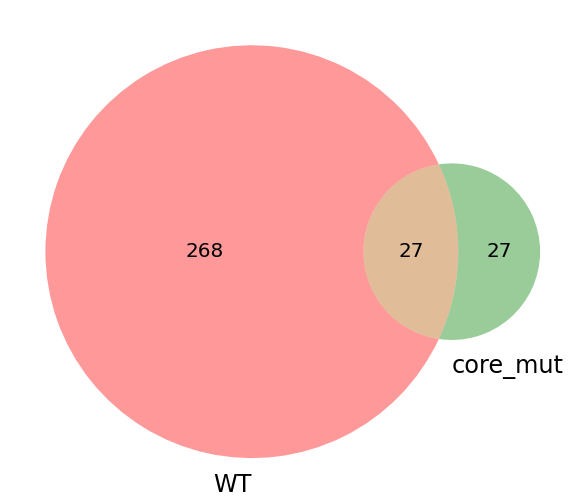

In [13]:
# down
trend = 'down'
mouse = 'a3922'
all_degs = []

results_table_file = results_table_dir + 'deseq2_' + mouse + '_' + trend + '.tsv'
df = pandas.read_csv(results_table_file, sep='\t', index_col=0)
wt_down = set(df.index.to_list())
print(len(wt_down))
    
# Venn diagram
matplotlib_venn.venn2([wt_down, set(core_mut_down)], set_labels=('WT', 'core_mut'))

In [14]:
index = 0
for element in core_mut_down:
    if element not in wt_down:
        #index = indexCd63 mitf + 1
        gene_name = annotation.loc[element]['ext_gene']
        description = annotation.loc[element]['description'].split(' [')[0]
        print(index, element, gene_name, description)

0 ENSMUSG00000020190 Mknk2 MAP kinase-interacting serine/threonine kinase 2
0 ENSMUSG00000020121 Srgap1 SLIT-ROBO Rho GTPase activating protein 1
0 ENSMUSG00000050390 C77080 expressed sequence C77080
0 ENSMUSG00000014444 Piezo1 piezo-type mechanosensitive ion channel component 1
0 ENSMUSG00000023009 Nckap5l NCK-associated protein 5-like
0 ENSMUSG00000013653 1810065E05Rik RIKEN cDNA 1810065E05 gene
0 ENSMUSG00000025351 Cd63 CD63 antigen
0 ENSMUSG00000024846 Cst6 cystatin E/M
0 ENSMUSG00000046352 Gjb2 gap junction protein, beta 2
0 ENSMUSG00000040606 Kazn kazrin, periplakin interacting protein
0 ENSMUSG00000037049 Smpd1 sphingomyelin phosphodiesterase 1, acid lysosomal
0 ENSMUSG00000036046 5031439G07Rik RIKEN cDNA 5031439G07 gene
0 ENSMUSG00000015766 Eps8 epidermal growth factor receptor pathway substrate 8
0 ENSMUSG00000019726 Lyst lysosomal trafficking regulator
0 ENSMUSG00000035273 Hpse heparanase
0 ENSMUSG00000045917 Tmem268 transmembrane protein 268
0 ENSMUSG00000024589 Nedd4l neura

# 4. PCA on DEGs

In [15]:
mice = ['a3922', 'a4774', 'a4775', 'a4776']
trends = ['up', 'down']

In [16]:
all_degs = []
for mouse in mice:
    for trend in trends:
        results_table_file = results_table_dir + 'deseq2_' + mouse + '_' + trend + '.tsv'
        df = pandas.read_csv(results_table_file, sep='\t', index_col=0)
        elements = df.index.to_list()
        all_degs.append(elements)
        print(len(elements))

602
295
192
93
376
213
342
150


In [17]:
results_union = list(set().union(*all_degs))
print(len(results_union))

1398


In [18]:
selected = expression.loc[results_union, :]
transpose = selected.transpose()
pca_tpms = numpy.log2(transpose + 1)
print(pca_tpms.shape)
pca_tpms.head()

(35, 1398)


,ENSMUSG00000020190,ENSMUSG00000021583,ENSMUSG00000041912,ENSMUSG00000038393,ENSMUSG00000039691,ENSMUSG00000057751,ENSMUSG00000117748,ENSMUSG00000057137,ENSMUSG00000024451,ENSMUSG00000029430,...,ENSMUSG00000094719,ENSMUSG00000035842,ENSMUSG00000050931,ENSMUSG00000111738,ENSMUSG00000087610,ENSMUSG00000039375,ENSMUSG00000032254,ENSMUSG00000037010,ENSMUSG00000042745,ENSMUSG00000018507
a3922_0h_1,6.835051,2.520182,1.632754,8.298629,9.133639,4.615772,3.707735,5.827576,1.982026,7.076412,...,2.331051,2.220434,1.274680,1.699946,2.720694,0.565718,3.741304,2.274198,4.581879,5.068342
a3922_0h_2,6.994570,2.642123,1.805139,8.214133,9.251795,4.802748,3.399711,5.755635,0.693984,7.103179,...,1.238326,2.178610,1.885381,3.019567,3.352472,0.775035,3.790670,2.267773,4.444086,5.156216
a3922_0h_3,6.922847,2.703639,1.302301,8.317077,9.287084,4.828355,3.231811,5.820743,1.492398,6.969446,...,0.000000,2.356106,2.121686,2.566802,2.451843,0.650045,3.398777,2.196470,4.475787,5.146995
a3922_48h_1,6.333818,2.879362,3.063876,6.431250,7.968741,3.257375,4.765133,3.580057,1.950241,8.442739,...,2.267240,2.961358,3.142932,2.927711,1.726872,1.336344,5.225081,2.836635,6.388922,4.458482
a3922_48h_2,6.374259,2.355526,2.745854,6.378096,7.940497,3.017196,4.593927,3.263519,2.712493,8.400572,...,0.000000,3.239389,3.464474,2.955741,0.889677,0.801071,5.172111,2.693440,6.294989,4.376214


In [19]:
import sklearn, sklearn.decomposition, sklearn.preprocessing

In [20]:
100

100

In [21]:
scaled_data = sklearn.preprocessing.StandardScaler().fit_transform(pca_tpms)
model = sklearn.decomposition.PCA(n_components=2)
new = model.fit_transform(scaled_data)
explained = model.explained_variance_ratio_

In [22]:
the_colors = []
for element in pca_tpms.index:
    if mice[0] in element:
        the_colors.append('black')
    elif mice[1] in element:
        the_colors.append('tab:red')
    elif mice[2] in element:
        the_colors.append('tab:orange')
    elif mice[3] in element:
        the_colors.append('gold')
    else:
        print('error')
        
the_markers = []
for element in pca_tpms.index:
    if '0h' in element:
        the_markers.append('o')
    elif '48h' in element:
        the_markers.append('v')
    elif '72h' in element:
        the_markers.append('^')
    else:
        print('error')

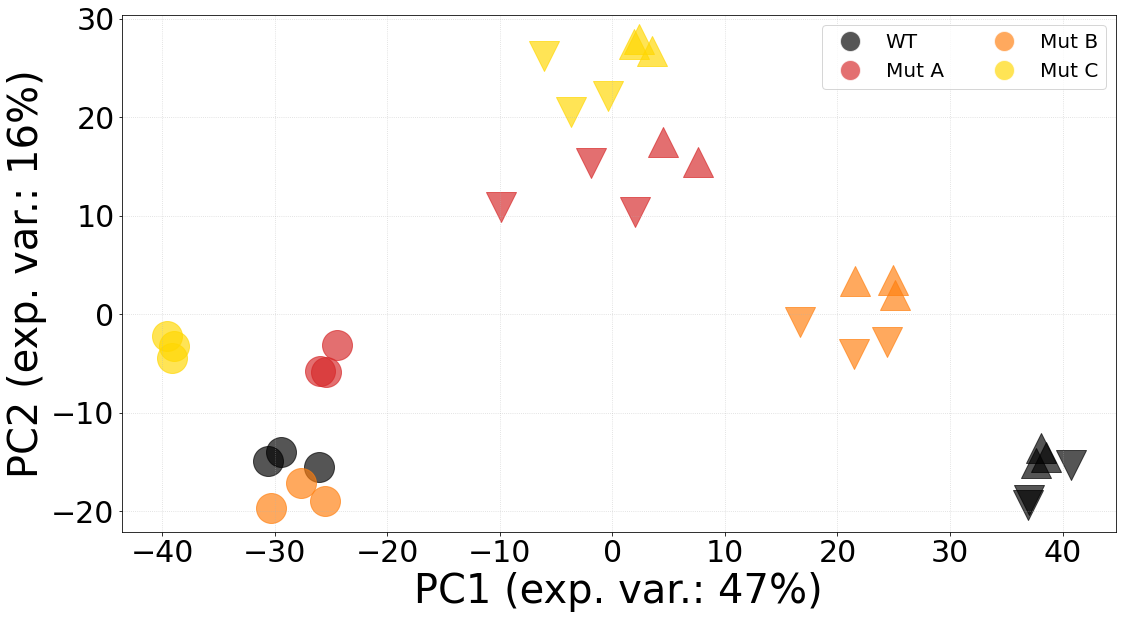

In [23]:
for i in range(len(new)):
    matplotlib.pyplot.scatter(new[i,0], new[i,1], s=900, c=the_colors[i], marker=the_markers[i], alpha=2/3)
    
legend_elements = [
    matplotlib.lines.Line2D([0], [0], color='white', marker='o', markerfacecolor='black', markersize=20, alpha=2/3),
    matplotlib.lines.Line2D([0], [0], color='white', marker='o', markerfacecolor='tab:red', markersize=20, alpha=2/3),
    matplotlib.lines.Line2D([0], [0], color='white', marker='o', markerfacecolor='tab:orange', markersize=20, alpha=2/3),
    matplotlib.lines.Line2D([0], [0], color='white', marker='o', markerfacecolor='gold', markersize=20, alpha=2/3)
]
matplotlib.pyplot.legend(legend_elements, ['WT', 'Mut A', 'Mut B', 'Mut C'], ncol=2)

matplotlib.pyplot.xlabel('PC1 (exp. var.: {}%)'.format(int(explained[0]*100)))
matplotlib.pyplot.ylabel('PC2 (exp. var.: {}%)'.format(int(explained[1]*100)))
matplotlib.pyplot.grid(alpha=0.5, ls=':')
matplotlib.pyplot.tight_layout()

- Observation 1. Induction timepoints 48h and  72 h are very similar, within each phenotype.
- Observation 2. Quite some variability in mutants at time zero. More than induction variability for a particular biological replicate.


- Moving forward. Let's compare 72 hours induced to their controls and remove DEGs that appear WT time trajectory. Those should the genes responding to the induction.In other words, get the DEGs on 72 h induced and compared them against their controls. Then sort them on delta log2 FC compared to WT transition.

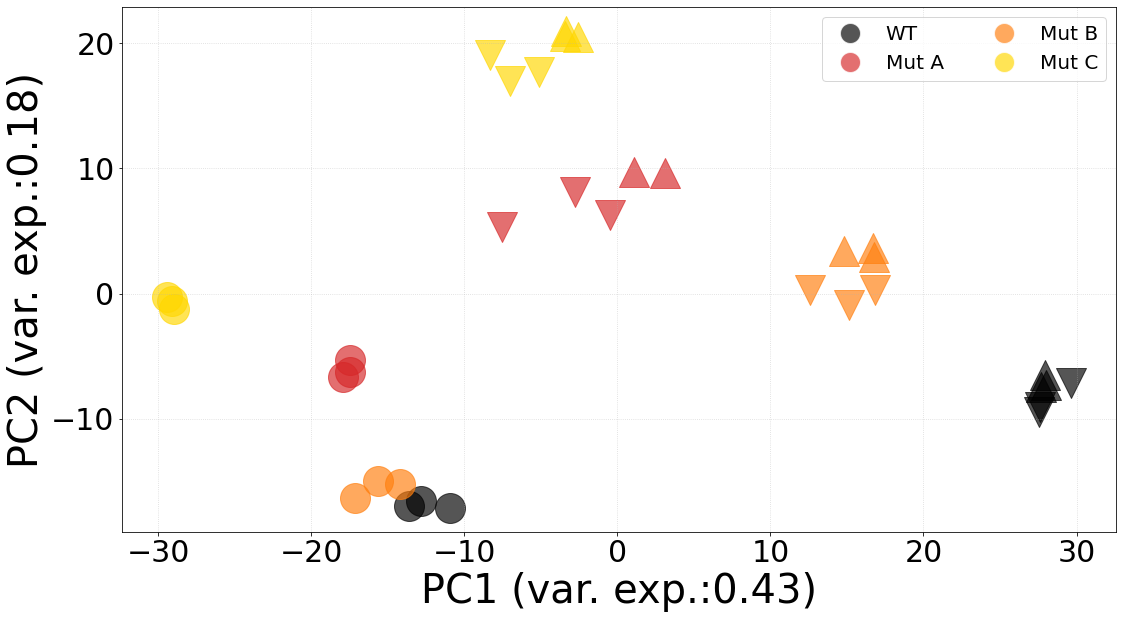

In [24]:
# comparison with non-scaled data
model = sklearn.decomposition.PCA(n_components=2)
new = model.fit_transform(pca_tpms)
explained = model.explained_variance_ratio_

for i in range(len(new)):
    matplotlib.pyplot.scatter(new[i,0], new[i,1], s=900, c=the_colors[i], marker=the_markers[i], alpha=2/3)
    
legend_elements = [
    matplotlib.lines.Line2D([0], [0], color='white', marker='o', markerfacecolor='black', markersize=20, alpha=2/3),
    matplotlib.lines.Line2D([0], [0], color='white', marker='o', markerfacecolor='tab:red', markersize=20, alpha=2/3),
    matplotlib.lines.Line2D([0], [0], color='white', marker='o', markerfacecolor='tab:orange', markersize=20, alpha=2/3),
    matplotlib.lines.Line2D([0], [0], color='white', marker='o', markerfacecolor='gold', markersize=20, alpha=2/3)
]
matplotlib.pyplot.legend(legend_elements, ['WT', 'Mut A', 'Mut B', 'Mut C'], ncol=2)

matplotlib.pyplot.xlabel('PC1 (var. exp.:{0:.2f})'.format(explained[0]))
matplotlib.pyplot.ylabel('PC2 (var. exp.:{0:.2f})'.format(explained[1]))
matplotlib.pyplot.grid(alpha=0.5, ls=':')
matplotlib.pyplot.tight_layout()

# 5. UMAP

In [25]:
embedding = umap.UMAP().fit_transform(scaled_data)

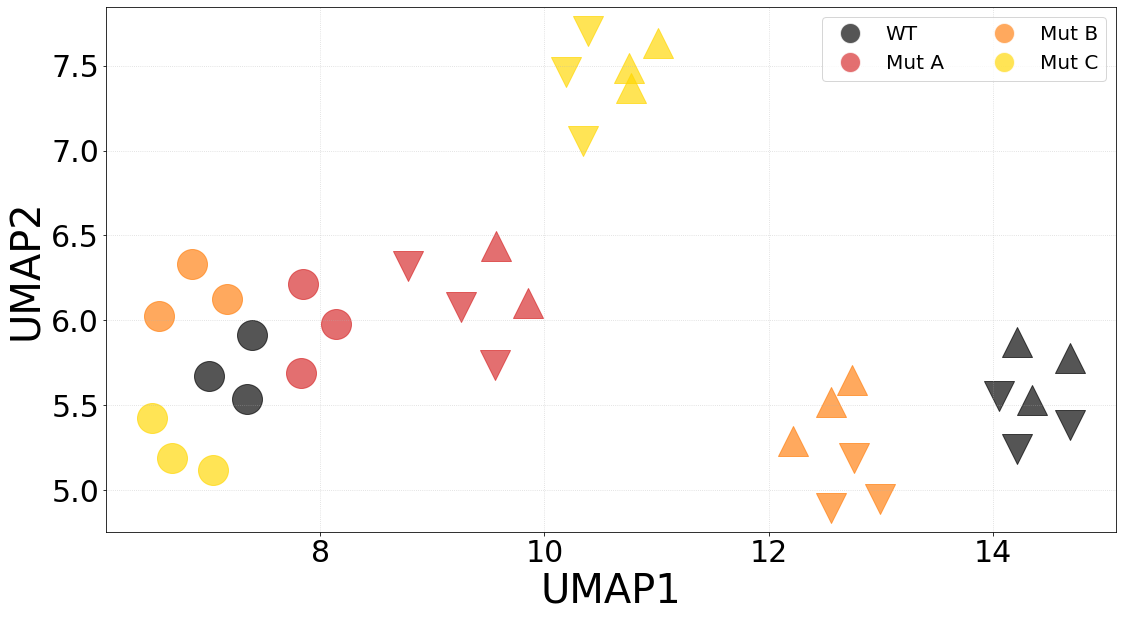

In [26]:
for i in range(len(new)):
    matplotlib.pyplot.scatter(embedding[i,0], embedding[i,1], s=900, c=the_colors[i], marker=the_markers[i], alpha=2/3)

legend_elements = [
    matplotlib.lines.Line2D([0], [0], color='white', marker='o', markerfacecolor='black', markersize=20, alpha=2/3),
    matplotlib.lines.Line2D([0], [0], color='white', marker='o', markerfacecolor='tab:red', markersize=20, alpha=2/3),
    matplotlib.lines.Line2D([0], [0], color='white', marker='o', markerfacecolor='tab:orange', markersize=20, alpha=2/3),
    matplotlib.lines.Line2D([0], [0], color='white', marker='o', markerfacecolor='gold', markersize=20, alpha=2/3)
]
matplotlib.pyplot.legend(legend_elements, ['WT', 'Mut A', 'Mut B', 'Mut C'], ncol=2)
    
matplotlib.pyplot.xlabel('UMAP1')
matplotlib.pyplot.ylabel('UMAP2')
matplotlib.pyplot.grid(alpha=0.5, ls=':')
matplotlib.pyplot.tight_layout()

- Conclusion: it does not seem to be worth to run UMAP. Very similar results than PCA.